*********
# SSDA - Social Media Mining Workshop
### Caleb Lucas
#### [caleblucas.com](https://www.caleblucas.com)
#### [@calebjlucas](https://www.twitter.com/calebjlucas)  

*********

We are using the `rtweet` package in `R`

In [ ]:
# install.packages("")
library(rtweet)
library(ggplot2)
library(tidytext)
library(stringr)
library(lubridate)
library(dplyr)
library(tm)
library(dplyr)
library(syuzhet)
library(igraph)

***

### Documentation

[rtweet documentation](https://cran.r-project.org/web/packages/rtweet/rtweet.pdf)  
[rtweet website](https://rtweet.info/)
***

## Set Up Authorization

API Keys. Keep them secert and keep them safe! People can do some damage if they get ahold of them. Don't share them. I have personally seen people post them in Github questions.

Note: If you end up making multiple accounts to access the API for whatever reason (beat rate limits, if you don't want to use your personal account, etc.) then be sure to track which keys are associated with what account.

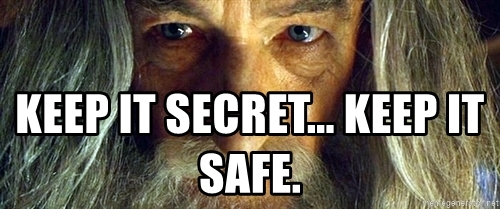

In [ ]:
api_key <- ""
api_secret_key <- ""

access_token <- ""
access_token_secret <- ""

You have to authenticate with the API.

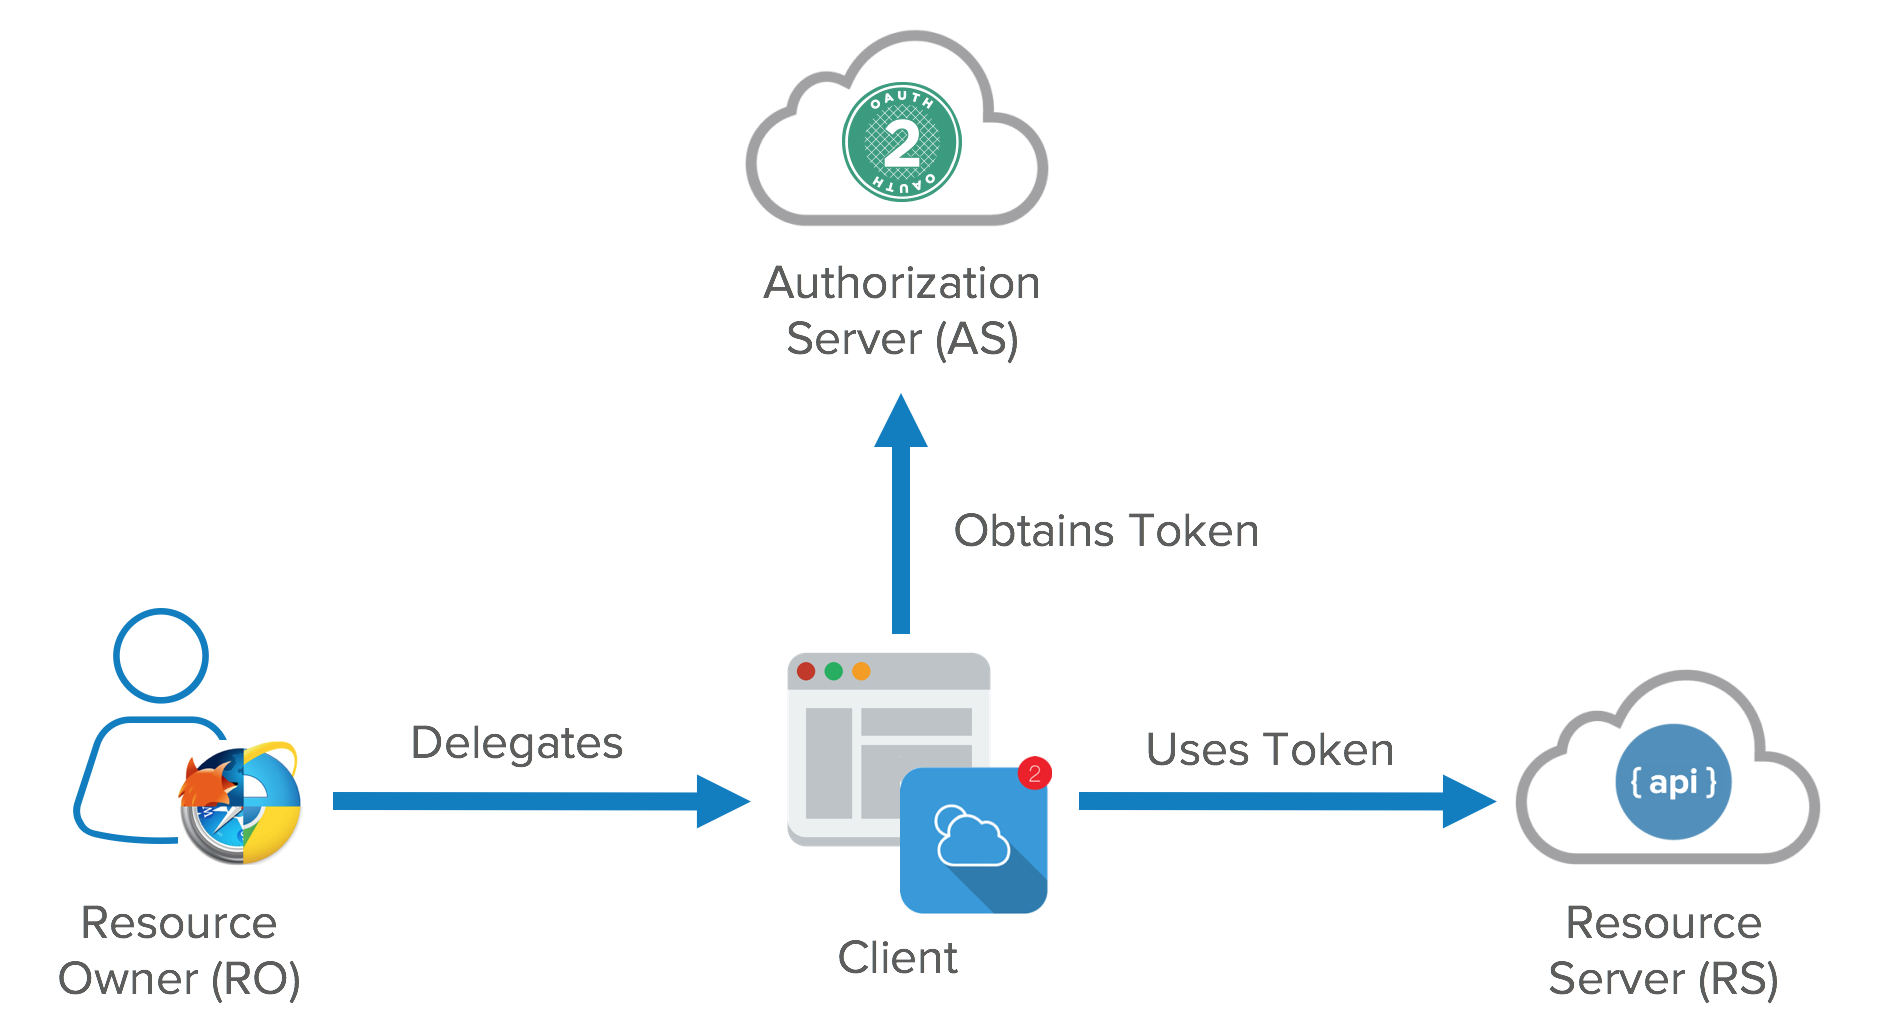

In [ ]:
# authenticate with web browser
token <- create_token(
  app = "r_ssda",
  consumer_key = api_key,
  consumer_secret = api_secret_key,
  access_token = access_token,
  access_secret = access_token_secret,
  set_renv = FALSE)

token

***
## Rate Limit - Rules Regarding What You Can Get 
***

Rate limits are the number of API calls you can make during a given window. You can see how close you are to being rate limited with the code below.

In [ ]:
# check status look up
rate_limit("followers")
cat(rep("-",53))
# look all limits up
rate_limit()

***
## Get Trends
***

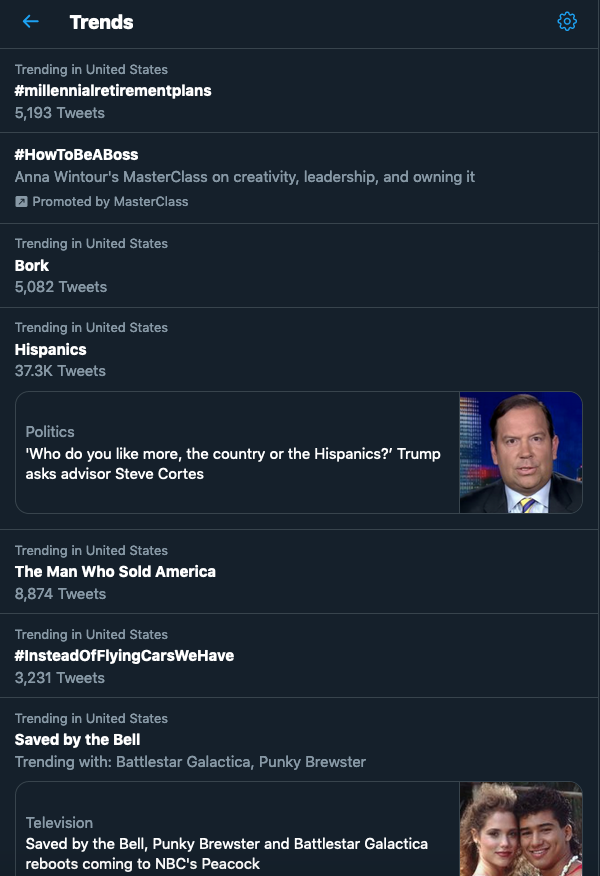

### From Twitter:

#### How are trends determined?

Trends are determined by an algorithm and, by default, are tailored for you based on who you follow, your interests, and your location. This algorithm identifies topics that are popular now, rather than topics that have been popular for a while or on a daily basis, to help you discover the hottest emerging topics of discussion on Twitter.

#### Availability:

They are generally available for the following countries and cities:

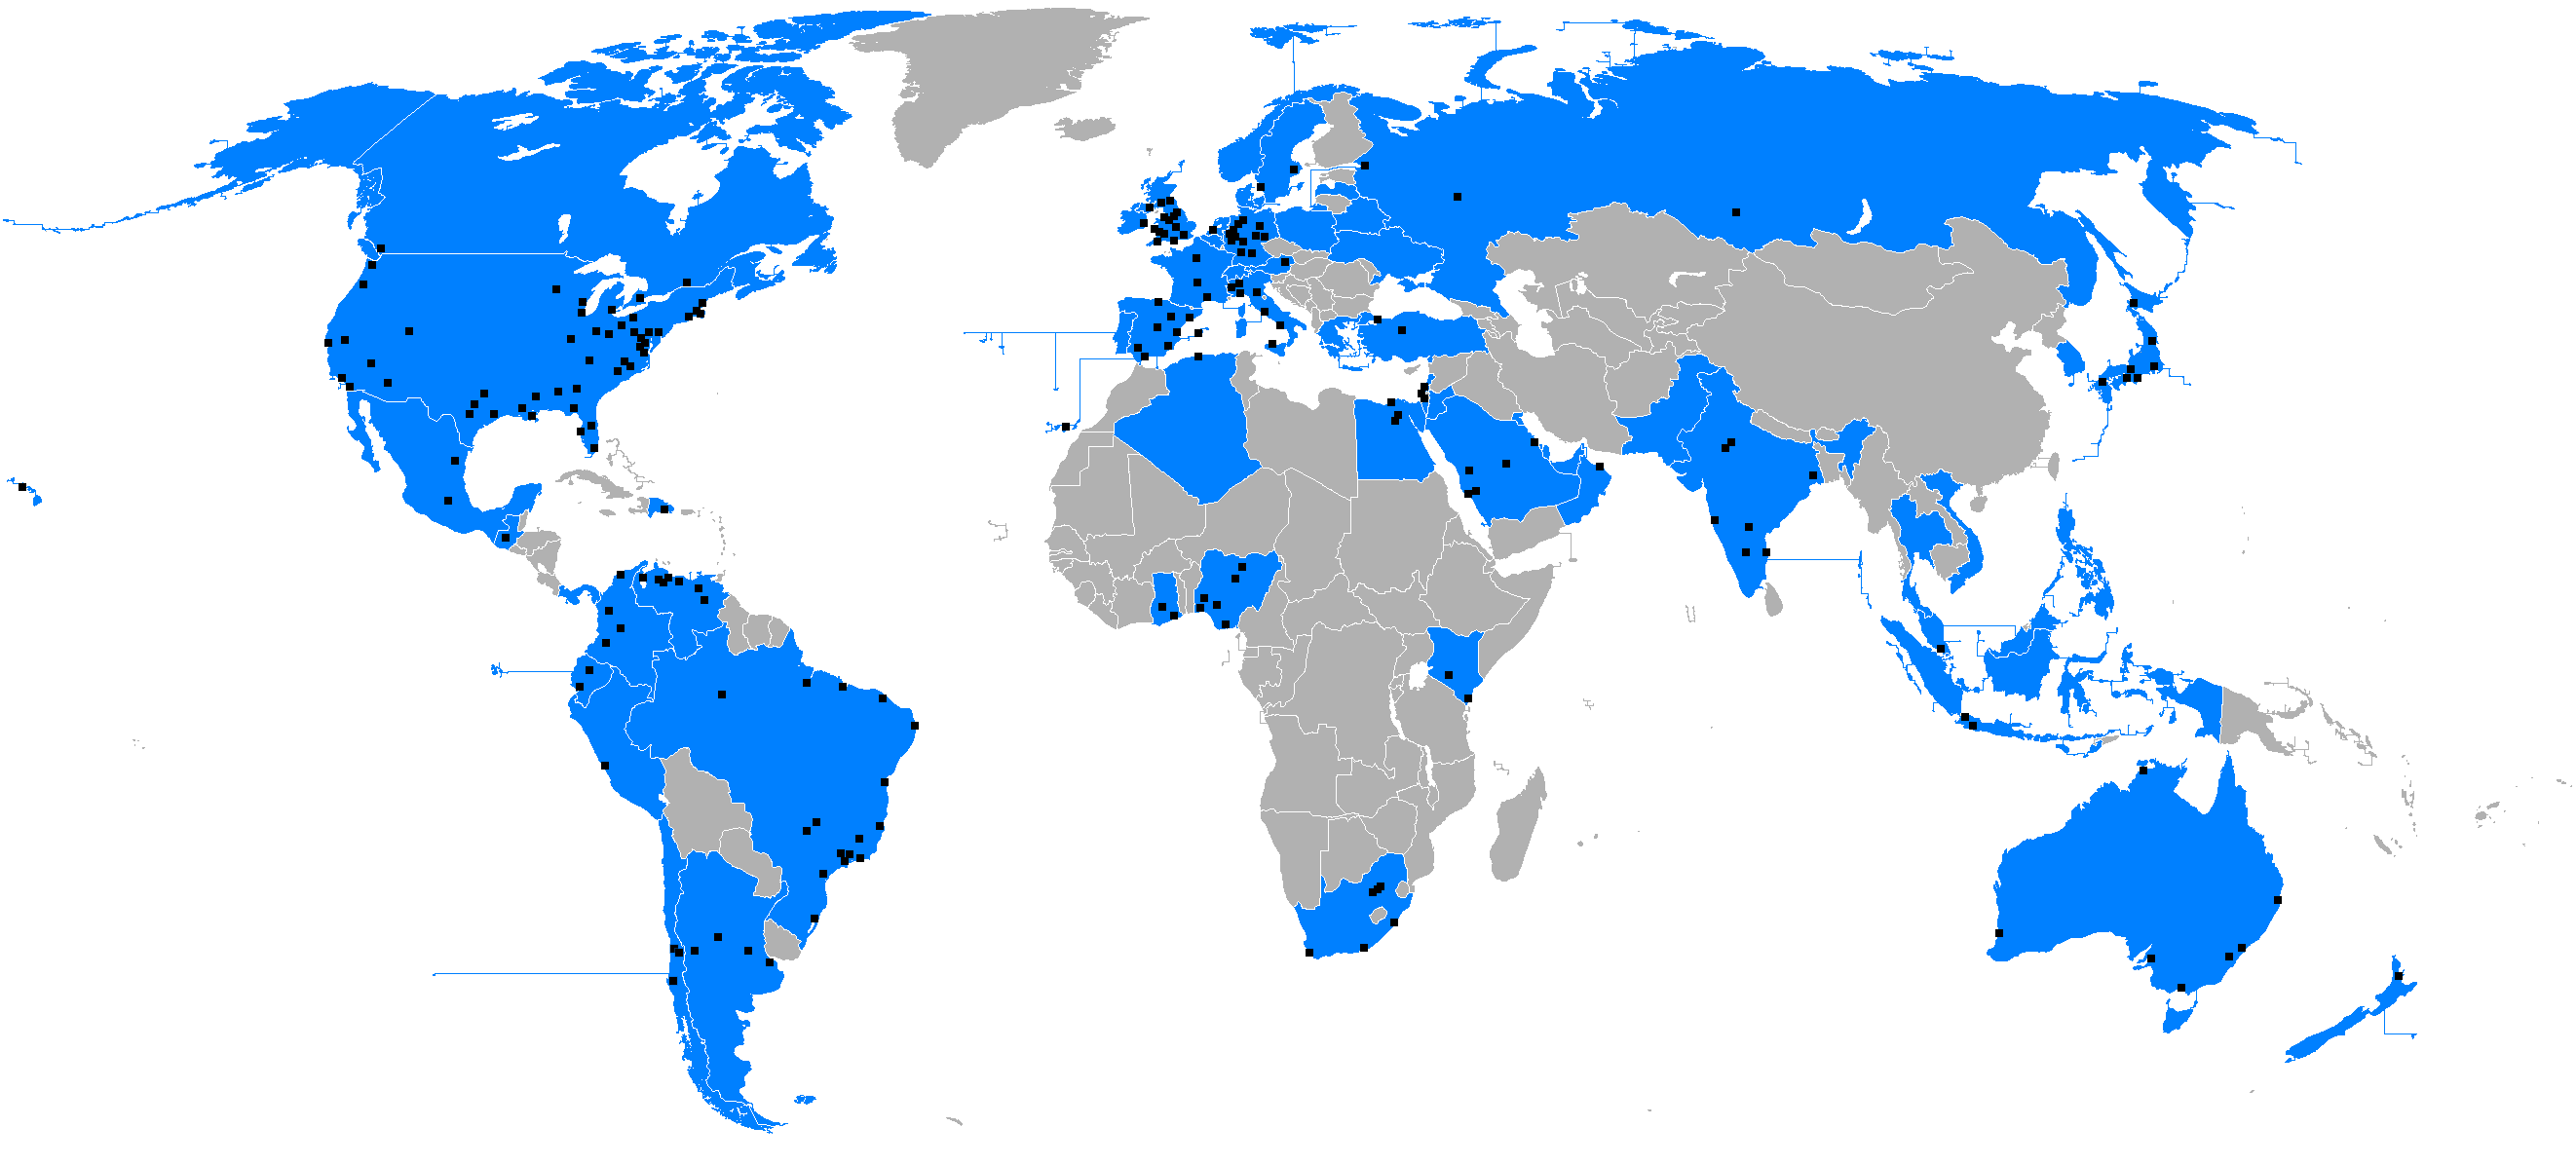

Want location-specific trends? use the trends_available() function to find out what locations are available. Use the woeid to look up trends in a specific location

In [ ]:
trends <- trends_available()
trends

Now find trends for the US + Detroit using the results from above trends for US + Detroit using the US woeid

In [ ]:
us_trends <- get_trends(woeid = 23424977) # US
detroit_trends <- get_trends(woeid = 2391585) # Detroit

take a look at the trends in the whole US

In [ ]:
us_trends[1:15,]

take a look at the trends in detroit

In [ ]:
detroit_trends[1:15,]

***
## Followers and Followees
***

* The API calls accounts that someone follows 'friends'
* 'Followers' are people that follow another use
* This is one way to create networks on Twitter

First, get friends - really easy function

In [ ]:
friends <- get_friends("calebjlucas",
                       n = 100,                # how many friends do you want to retrieve?
                       retryonratelimit = TRUE # retry if you go over the API limits?
                      )

Take a look at the friends object

In [ ]:
head(friends)

Now, pass multiple accounts to the function

In [ ]:
my_accounts <- c("calebjlucas", "MSU_SocSci")
friends <- get_friends(my_accounts,             # multiple accounts at once
                       n = 100,                 # how many friends do you want to retrieve?
                       retryonratelimit = TRUE) # retry if you go over the API limits?

print the first/last 5 rows of the friends object

In [ ]:
friends[c(1:5, (nrow(friends)-5):nrow(friends)), ]


Next, get followers! very similar to the get_friends function

In [ ]:
followers <- get_followers("calebjlucas",
                       n = 100, # how many friends do you want to retrieve?
                       retryonratelimit = TRUE #retry if you go over the API limits?
                       )

Take a look at the resulting object

In [ ]:
cat("People that follow caleb:")
head(followers)

This cell will hit the rate limit - if it is still executing after a minute then interrupt and run the next cell

In [ ]:
followers_lim <- get_followers("BrendanNyhan", n = 999999, retryonratelimit = TRUE)

The cell above maxed out the rate limit. Use the rate_limit() function to see that you are over, sleep for 10 seconds, and notice how the time counts down to reset the limit

In [ ]:
# rate limiting at this point
rate_limit("followers")

# sleep for 10 seconds and notice the time going down
Sys.sleep(10)
rate_limit("followers")

The current followers object is full of user ids- they are hard to read, but easier to work with than usernames. Lets get user data to see people's username. What data fields are available in the resulting object?

In [ ]:
user_info <- lookup_users(followers$user_id[1:5])
head(user_info)


What data is returned from the lookup_users function?

In [ ]:
colnames(user_info)

Print a couple interesting columns in the user object

In [ ]:
user_info[1:5, c("name","description","location")]

Could you do a study that relies on collecting user profile images and codes them in some way? Maybe you are interested in getting images of faces and coding age or something? What other fields in the object could be useful or interesting?

***
## Stream Tweets
***

You can stream 1% of all Tweets being produced at any given time for free. A few studies have compared the full firehouse (ALL tweets being produced)/the decahose (10% of all tweets) with this stream and it is generally representative of all of Twitter. Streaming can be really useful for funding users to scrape (snow ball sampling)- perhaps in a specific location, collecting a representative sample of tweets about a certain term, etc. 

In [ ]:
# random 1% of real-time tweets
stream <- stream_tweets(q = "", timeout = 60) #default timeout is 30 seconds
head(stream)

Streaming can produce an absurd amount of data.

In [ ]:
cat("Number of streamed tweets in 60 seconds:", nrow(stream), "\n")
cat("Number of tweets in 24 hours at same rate:", nrow(stream) * 1440) # 1440 minutes in a day

Use the package pryr to understand the scale of the data. Just a day or two of streaming can produce huge amounts of data:

In [ ]:
format(object.size(stream), units = "auto")

NOTE: this is for a world stream. With further search restrictions (words, locations, etc) the amount of data will be smaller)

***

IMPORTANT: You can to balance two things with social media data collection:

* What fields do you need?
* What data do you think you MIGHT need in the future?

You have to balance these things with the huge amounts of storage required to keep everything - it isn't always an option to simply store all the fields of a tweet. You might have to subset and only keep some due to memory limits. Just be careful that after months of data collection you wished you have one or two extra fields. It isn't always an option to keep everything.

***

Plot the number of tweets by the time streaming

In [ ]:
stream %>%
  ts_plot("1 second") +
  ggplot2::theme_minimal() +
  ggplot2::theme(plot.title = ggplot2::element_text(face = "bold")) +
  ggplot2::labs(
    x = "Time", y = "Number of Tweets",
    title = "Twitter Stream"
  )

***
## Search Tweets
***

search for a keyword

In [ ]:
tweets <- search_tweets(q = "msu", n = 5)
tweets

search for phrase

In [ ]:
tweets <- search_tweets(q = '"michigan state"', n = 5) # looks for exact phrase (See quotes)
tweets

search for multiple words - together

In [ ]:
tweets <- search_tweets(q = "msu AND uk", n = 5)
tweets

search for multiple words - or

In [ ]:
tweets <- search_tweets(q = "msu OR uk", n = 5)
tweets

search with language restriction

In [ ]:
tweets <- search_tweets(q = "Liban", lang = "fr", n = 5) # search for Lebanon in French
tweets

search within specified location

In [ ]:
tweets <- search_tweets(q = "", n = 5, geocode = "42.73,-84.48,15mi") # east lansing
tweets

search with language

In [ ]:
tweets <- search_tweets(q = '"michigan state"', lang = "en", n = 5, include_rts = FALSE)
head(tweets)

Search is limited to 18,000 tweets in a single call (ie API will return 18k tweets before rate limiting you and making you wait) and only spans about the past week.

In [ ]:
# search for hashtag
trump_hashtag <- search_tweets("#impeachtrump", n = 5, include_rts = FALSE)
trump_hashtag

Get 18,000 tweets mentioning trump

In [ ]:
trump_tweets <- search_tweets("trump", n = 18000, include_rts = FALSE)

This is the old way to do this to overcome the rate limiting, but its still useful to know since it can help if you need to go back and collect more tweets after an initial search

In [ ]:
# select last (oldest) status ID from previous search
last_status_id <- trump_tweets$status_id[nrow(trump_tweets)]

# pass last_status_id to max_id and run search again.
trump_tweets_contd <- search_tweets(
    "trump",
    n = 18000, 
    include_rts = FALSE,
    max_id = last_status_id)

Instead, like earlier, use rtweet's great retryonratelimit = TRUE argument. 

*NOTE*: this will run for days, so go ahead and interrupt it or don't run it.

In [ ]:
lots_of_trump <- search_tweets("trump", n = 999999, retryonratelimit = TRUE, include_rts = FALSE)

***
## Timeline
***

Get someone's timeline with get_timeline- this is a real workhorse function.

In [ ]:
caleb_twitter <- get_timeline("calebjlucas", n = 3200)

In [ ]:
head(caleb_twitter)

In [ ]:
colnames(caleb_twitter)

Use rtweet's ts_plot function to plot tweets over time

In [ ]:
caleb_twitter %>%
  ts_plot("2 days") +
  ggplot2::theme_minimal() +
  ggplot2::theme(plot.title = ggplot2::element_text(face = "bold")) +
  ggplot2::labs(
    x = "Time", y = "Number of Tweets",
    title = ".",
    subtitle = "."
  )

***
## Send DM
***

You can send direct messages with the post_message function.

In [ ]:
# post_message("Hey Caleb!!!", user = "calebjlucas")

***
## Get Specific Account Info
***

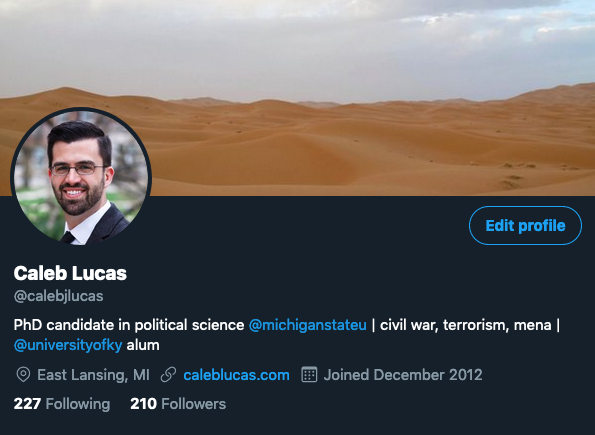

get my user profile data

In [ ]:
caleb_profile <- search_users("calebjlucas")
# function matched multiple users, subset to include only my profile
caleb_profile <- subset(caleb_profile, screen_name == "calebjlucas")

In [ ]:
caleb_profile

print the fields returned by the search_users function

In [ ]:
for(i in 1:ncol(caleb_profile)){
    cat(colnames(caleb_profile)[i],"\n")
}

In [ ]:
caleb_profile$name

In [ ]:
caleb_profile$description

In [ ]:
caleb_profile$location

In [ ]:
caleb_profile$account_created_at

## List of rtweet's functions that harvest data from the Twitter API


***
* get_collections: Get collections by user or status id.
* get_favorites: Get tweets data for statuses favorited by one or more target users.
* get_followers: Get user IDs for accounts following target user.
* get_friends: Get user IDs of accounts followed by target user(s).
* get_mentions: Get mentions for the authenticating user.
* get_retweeters: Get user IDs of users who retweeted a given status.
* get_retweets: Get the most recent retweets of a specific Twitter status
* get_timeline: Get one or more user timelines (tweets posted by target user(s)).
* get_timelines: Get one or more user timelines (tweets posted by target user(s)).
* lookup_collections: Get collections by user or status id.
* lookup_coords: Get coordinates of specified location.
* lookup_friendships: Lookup friendship information between two specified users.
* lookup_statuses: Get tweets data for given statuses (status IDs).
* lookup_tweets: Get tweets data for given statuses (status IDs).
* lookup_users: Get Twitter users data for given users (user IDs or screen names).
* search_tweets: Get tweets data on statuses identified via search query.
* search_users: Get users data on accounts identified via search query.
* stream_tweets: Collect a live stream of Twitter data.
***


***
## Clean Texts
***

Tweets are messy and often need to be cleaned before analyzing them. This is a huge topic with lots of domain-specific quirks and corpus-specific issues. Here we do some simple cleaning to demonstrate the importance of thinking through how/what to clean and how it might affect your analysis.

Things to think about-

* Punctuation
* Emojis
* Whitespace
* Common words (the, an, a)
* Numbers
* URLs
* etc.

Think about what might affect *your* analysis and how - what should you do to make sure the data (text/emojis) is appropriate for your analysis? There are not hard rules regarding how to do this.

First, get some data.

In [ ]:
cnn <- get_timeline("cnn", n = 3200)
head(cnn)

rtweet function to make tweet text plain text. function produces text that is reformatted with ascii encoding and normal ampersands and without URL links, line breaks, fancy spaces/tabs, fancy apostrophes.

In [ ]:
cnn <- plain_tweets(cnn)

We will separate (or tokenize) the tweets into words for clenaing and basic analysis. This is typical for many projects, but you can also tokenize with characters, n-grams (sets of words), paragraphs, etc.

In [ ]:
cnn_words <- cnn %>%
  dplyr::select(text) %>%
  tidytext::unnest_tokens(word, text)

In [ ]:
cnn_words[1:10,]
cnn$text[1]

plot the top 15 words

In [ ]:
cnn_words %>%
  count(word, sort = TRUE) %>%
  top_n(15) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
      labs(x = "Count",
      y = "Unique words",
      title = "Count of unique words found in tweets")

Notice that in the plot above all the top words are not words that we are interested in - they don't convey substantively important meaning. So, when conducting text analysis, we drop these words and clean the text of all extra symbols, markers, numbers, etc.

In [ ]:
cnn_words[1:20, ]

In [ ]:
data(stop_words)

cnn_words <- cnn_words %>%
  anti_join(stop_words)

In [ ]:
head(cnn_words)

We perform a number of processing steps below. Think about them each and what effect they might have on your work. What else could you exclude? Research suggests that preprocessing steps MATTER, so think carefully about them. See this paper for example-

https://www.cambridge.org/core/journals/political-analysis/article/text-preprocessing-for-unsupervised-learning-why-it-matters-when-it-misleads-and-what-to-do-about-it/AA7D4DE0AA6AB208502515AE3EC6989E

In [ ]:
# to lowercase - this is a really important step
cnn_words$word <- tolower(cnn_words$word)

# unnecessary spaces
cnn_words$word <- str_squish(cnn_words$word)

In [ ]:
# drop urls
cnn_words$word <- str_replace_all(cnn_words$word,"\\s?(f|ht)(tp)(s?)(://)([^\\.]*)[\\.|/](\\S*)"," ") 
cnn_words$word <- str_replace_all(cnn_words$word,"t.co"," ") 

# drop nums
cnn_words$word <- str_replace_all(cnn_words$word,"[[:digit:]]"," ") 

In [ ]:
# drop rid of hashtags
cnn_words$word <- str_replace_all(cnn_words$word,"#[a-z,A-Z]*"," ")

# drop references to other screennames
cnn_words$word <- str_replace_all(cnn_words$word,"@[a-z,A-Z]*"," ") 

In [ ]:
# drop punc
cnn_words$word <- str_replace_all(cnn_words$word,"[[:punct:]]"," ") 

# drop where 's existed (we dropped punctuation so there will be things
# like this in the corpus : [trump s] where trump's used to be)
cnn_words$word <- str_replace_all(cnn_words$word,"\\ss"," ") 

# unnecessary spaces
cnn_words$word <- str_squish(cnn_words$word)
cnn_words$word <- str_trim(cnn_words$word, side = "both")


In [ ]:
cnn_words[1:20, ]

In [ ]:
cnn_words <- cnn_words[!(cnn_words$word == ""), ]
cnn_words %>%
  count(word, sort = TRUE) %>%
  top_n(25) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(x = word, y = n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip() +
  labs(title = "Count of Unique Words")

***
# Analyze Tweet Text
***

Analzying Twitter data-

* Network analysis (friends, influence, etc.)
* Text analysis (topic modeling, sentiment, etc.)
* Emojis
* Effect of exposure

***
## Sentiment Analysis
***

In [ ]:
trump <- get_timeline("realDonaldTrump", 
                      n = 3200, 
                      retryonratelimit = TRUE)

In [ ]:
trump$sent <- get_sentiment(trump$text, method = "bing")

In [ ]:
head(trump$created_at)

In [ ]:
trump$created_at_day <- as.Date(ymd_hms(trump$created_at))
head(trump$created_at_day)

In [ ]:
trump_agg <- trump %>% 
  group_by(created_at_day) %>%
  summarize(avg_sent = mean(sent))
head(trump_agg)

In [ ]:
ggplot(data = trump_agg, aes(x = created_at_day, y = avg_sent)) + 
  geom_line() +
  ylim(-1,1) + 
  theme_minimal()

***
## Emotions in Text
***

Code the emotion in tweets using the NRC Word-Emotion Association Lexicon, a handed coded dictionary that associates words with eight emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust)and positive/negative sentiment.

In [ ]:
nrc_sentiment <- get_nrc_sentiment(trump$text) 

In [ ]:
nrc_sentiment <- data.frame(colSums(nrc_sentiment))

In [ ]:
colnames(nrc_sentiment) <- "Score"

In [ ]:
sentimentscores <- cbind("sentiment" = rownames(nrc_sentiment), nrc_sentiment)

In [ ]:
ggplot(data = sentimentscores,aes(x = sentiment, y = Score)) +
  geom_bar(aes(fill = sentiment), stat = "identity") +
  theme(legend.position = "none") +
  xlab("sentiment") + 
  ylab("score") +
  ggtitle("Total Sentiment of Tweets") +
  theme_minimal()

***
## Network
***

Get friends of multiple accounts

In [ ]:
search_acc <- c("calebjlucas", "MSU_poli_sci", "shaylafolson", "SchellintheC",
                "ErikaaVallejo", "maxwelch_pls")
friends <- get_friends(search_acc)

Get frequency counts of accounts followed by the users from cell above, then subset to only those followed by a certain amount or more

In [ ]:
frq_table <- table(friends$user_id)
# change the 0 to a higher threshold if you would like
friends_sub <- subset(friends, user_id %in% names(frq_table[frq_table > 3]))

Convert to a matrix

In [ ]:
mat <- as.matrix(friends_sub)

Convert to graph object

In [ ]:
mat_graph <- igraph::graph_from_edgelist(mat)

Plot!

In [ ]:
igraph_options(plot.layout = layout_with_dh)
plot(mat_graph,
     edge.arrow.size = .2,
     vertex.size = 5,
     vertex.label = ifelse(V(mat_graph)$name %in% search_acc, V(mat_graph)$name, NA),
     main = "MSU Political Science Network"
)